In [63]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [64]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [65]:
actions = [
    'one',
    'two',
    'three'
]
name = "secret1"

# 만들었던 seq 데이터들 로드해서 하나로 만들어
data = np.concatenate([
    np.load("dataset/seq_{}_one.npy".format(name)),
    np.load("dataset/seq_{}_two.npy".format(name)),
    np.load("dataset/seq_{}_three.npy".format(name))
], axis=0)

data.shape
# 총 데이터셋 개수, 윈도우 사이즈, 한 윈도우 당 데이터 개수 일케 뜰겨

(604, 30, 100)

In [66]:
# 마지막 값 라벨이므로 빼주고 x데이터 만듦
x_data = data[:, :, :-1]

# 마지막값만 가지고 라벨로 만듦
labels = data[:, 0, -1]


print(x_data.shape)
print(labels.shape)
# 윈도우 당 데이터 00로 줄어들겨
# 라벨 개수 (총 데이터 수랑 같은 개수) 나올겨

(604, 30, 99)
(604,)


In [67]:
from tensorflow.keras.utils import to_categorical

# 라벨 0이면 [1,0,0], 라벨 1이면 [0,1,0] 이렇게 만드는 원핫인코딩 할겨
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(604, 3)

In [68]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# 90펴 -> 트레이닝 셋, 10퍼 -> 테스트셋으로 만듦
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(543, 30, 99) (543, 3)
(61, 30, 99) (61, 3)


In [69]:
# 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM과 Dense 2개 연결
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                41984     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [70]:
# 학습
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# model.fit 해서 학습. 200번 epochs 돌려
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)
# 정확도 높은 모델 따로 저장할겨

Epoch 1/200
13/17 [=====================>........] - ETA: 0s - loss: 70.0074 - acc: 0.2957
Epoch 1: val_acc improved from -inf to 0.22951, saving model to models/model.h5
17/17 [==============================] - 1s 21ms/step - loss: 63.9324 - acc: 0.2891 - val_loss: 34.3489 - val_acc: 0.2295 - lr: 0.0010
Epoch 2/200
15/17 [=========================>....] - ETA: 0s - loss: 45.0203 - acc: 0.3583
Epoch 2: val_acc improved from 0.22951 to 0.24590, saving model to models/model.h5
17/17 [==============================] - 0s 11ms/step - loss: 44.4691 - acc: 0.3573 - val_loss: 42.7248 - val_acc: 0.2459 - lr: 0.0010
Epoch 3/200
15/17 [=========================>....] - ETA: 0s - loss: 33.9052 - acc: 0.2604
Epoch 3: val_acc improved from 0.24590 to 0.27869, saving model to models/model.h5
17/17 [==============================] - 0s 11ms/step - loss: 33.4901 - acc: 0.2689 - val_loss: 36.5569 - val_acc: 0.2787 - lr: 0.0010
Epoch 4/200
15/17 [=========================>....] - ETA: 0s - loss: 26.8884

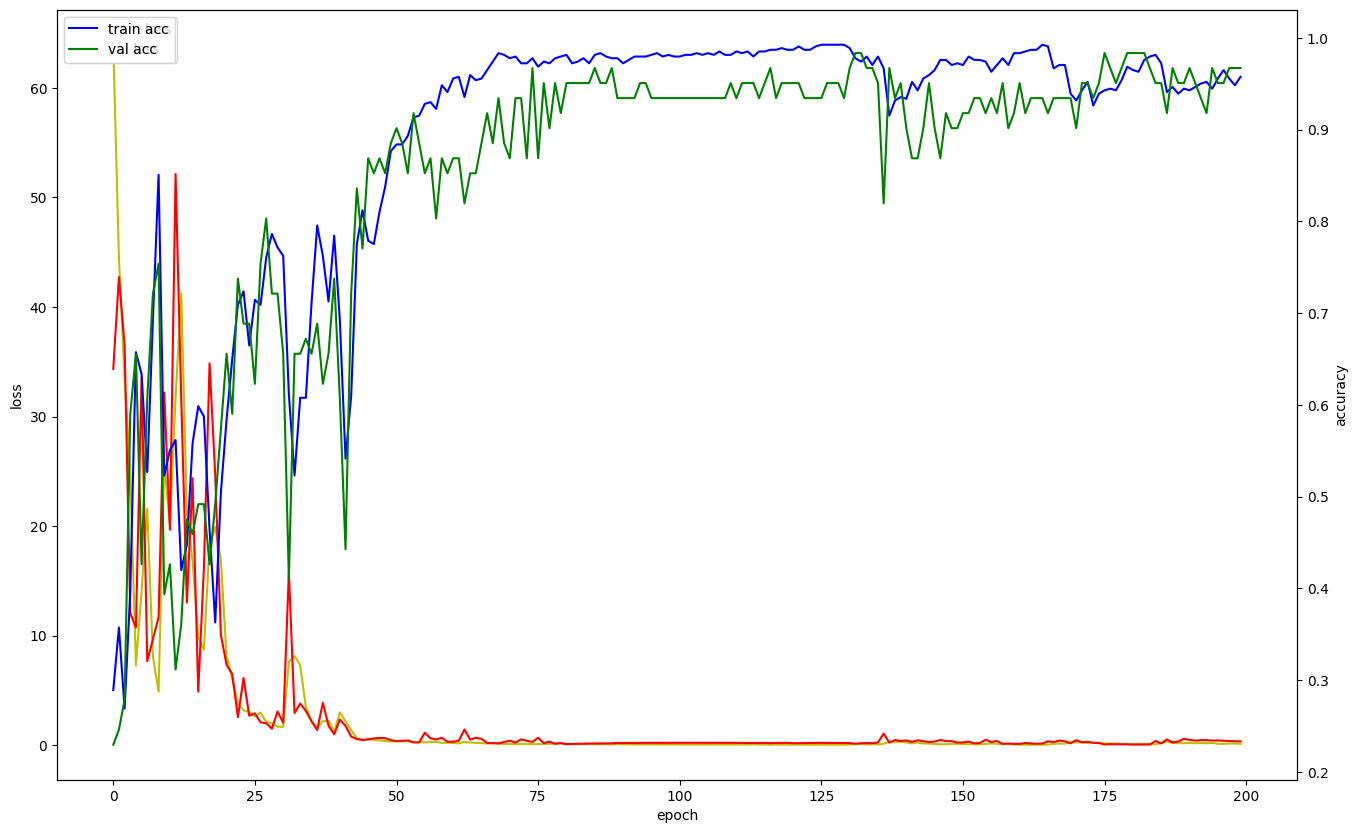

In [71]:
# 학습 완료 그래프
# 초파 -> train acc, val acc
# 노빨 -> loss
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [72]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

# 저장한 모델 로드
model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

2/2 [==============================] - 0s 5ms/step


array([[[39,  0],
        [ 1, 21]],

       [[38,  0],
        [ 0, 23]],

       [[44,  1],
        [ 0, 16]]])